**MOVIE GENRE CLASSIFICATION**

Importing all the necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk #a powerful library for working with human language data
from nltk.corpus import stopwords #for cleaning
from nltk.stem import LancasterStemmer ##for cleaning
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

Loading the training dataset

In [3]:
train_path="/content/train_data.txt"
train_data = pd.read_csv(train_path,sep=":::",names=[
    "TITLE","GENRE","DESCRIPTION"],engine="python")

In [4]:
train_data

,TITLE,GENRE,DESCRIPTION
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...
...,...,...,...
54210,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on ...
54211,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION. The sist...
54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about g..."
54213,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and hav...


Preprocessing on Training Data

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   TITLE        54214 non-null  object
 1   GENRE        54214 non-null  object
 2   DESCRIPTION  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [6]:
train_data.describe()

,TITLE,GENRE,DESCRIPTION
count,54214,54214,54214
unique,54214,27,54086
top,Oscar et la dame rose (2009),drama,Grammy - music award of the American academy ...
freq,1,13613,12


In [7]:
train_data.isnull().sum() #checking for null values

TITLE          0
GENRE          0
DESCRIPTION    0
dtype: int64

In [8]:
train_data.GENRE.unique()

array([' drama ', ' thriller ', ' adult ', ' documentary ', ' comedy ',
       ' crime ', ' reality-tv ', ' horror ', ' sport ', ' animation ',
       ' action ', ' fantasy ', ' short ', ' sci-fi ', ' music ',
       ' adventure ', ' talk-show ', ' western ', ' family ', ' mystery ',
       ' history ', ' news ', ' biography ', ' romance ', ' game-show ',
       ' musical ', ' war '], dtype=object)

Loading the testing dataset

In [10]:
test_path="/content/test_data.txt"
test_data = pd.read_csv(test_path,sep=":::",names=[
    "TITLE","DESCRIPTION"],engine="python")
test_data.head()

,TITLE,DESCRIPTION
1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
5,Er nu zhai (1955),Before he was known internationally as a mart...


Preprocessing on testing data

In [11]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54200 entries, 1 to 54200
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   TITLE        54200 non-null  object
 1   DESCRIPTION  54200 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [12]:
test_data.describe()

,TITLE,DESCRIPTION
count,54200,54200
unique,54200,54072
top,Edgar's Lunch (1998),Grammy - music award of the American academy ...
freq,1,10


In [13]:
test_data.duplicated().sum()

0

Exploratory Data Analysis(EDA)

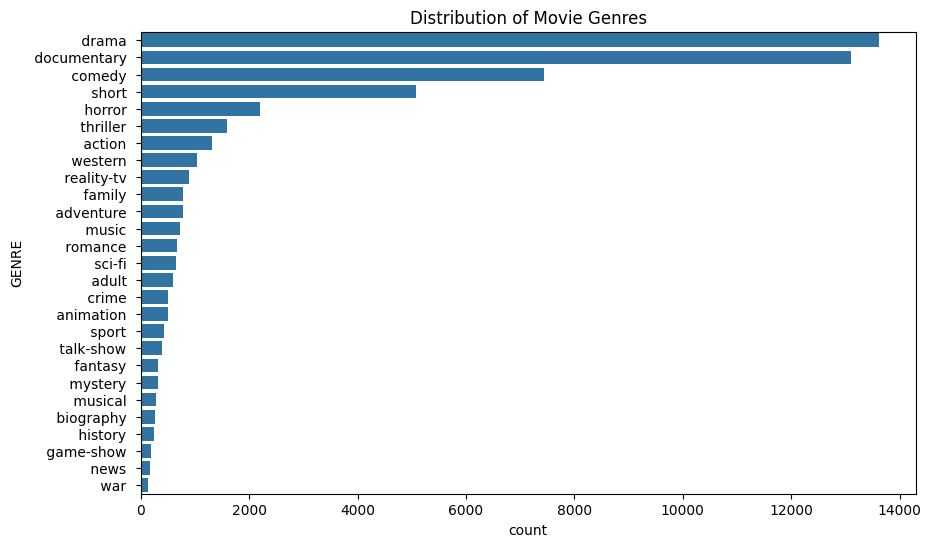

In [14]:
plt.figure(figsize=(10,6))
sns.countplot(y=train_data['GENRE'], order=train_data['GENRE'].value_counts().index)
plt.title('Distribution of Movie Genres')
plt.show()

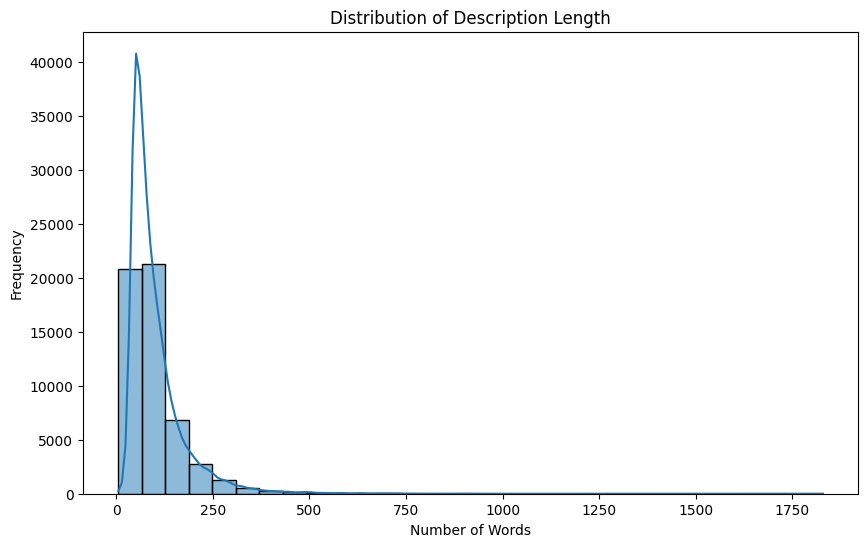

In [15]:
train_data['DESC_LEN'] = train_data['DESCRIPTION'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10,6))
sns.histplot(train_data['DESC_LEN'], kde=True, bins=30)
plt.title('Distribution of Description Length')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

Download NLTK resources

In [16]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Data Preprocessing

In [17]:
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

train_data['CLEAN_DESCRIPTION'] = train_data['DESCRIPTION'].apply(preprocess_text)
test_data['CLEAN_DESCRIPTION'] = test_data['DESCRIPTION'].apply(preprocess_text)

Feature Extraction

In [18]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=2000)
X_train = tfidf_vectorizer.fit_transform(train_data['CLEAN_DESCRIPTION'])
y_train = train_data['GENRE']

In [19]:
X_test = tfidf_vectorizer.transform(test_data['CLEAN_DESCRIPTION'])

Model Training

In [20]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Multinomial Naive Bayes

In [21]:
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()
nb_model.fit(X_train_part, y_train_part)
nb_pred = nb_model.predict(X_valid)

In [22]:
print("Naive Bayes Accuracy:", accuracy_score(y_valid, nb_pred))
print("Naive Bayes Classification Report:\n", classification_report(y_valid, nb_pred))

Naive Bayes Accuracy: 0.5077930462049248


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Naive Bayes Classification Report:
                precision    recall  f1-score   support

      action        0.56      0.06      0.10       263
       adult        1.00      0.01      0.02       112
   adventure        0.25      0.01      0.01       139
   animation        0.00      0.00      0.00       104
   biography        0.00      0.00      0.00        61
      comedy        0.48      0.38      0.42      1443
       crime        0.00      0.00      0.00       107
 documentary        0.56      0.87      0.68      2659
       drama        0.44      0.82      0.58      2697
      family        1.00      0.01      0.01       150
     fantasy        0.00      0.00      0.00        74
   game-show        1.00      0.33      0.49        40
     history        0.00      0.00      0.00        45
      horror        0.69      0.29      0.41       431
       music        0.67      0.27      0.39       144
     musical        0.00      0.00      0.00        50
     mystery        0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(max_iter=200)
lr_model.fit(X_train_part, y_train_part)
lr_pred = lr_model.predict(X_valid)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
print("Logistic Regression Accuracy:", accuracy_score(y_valid, lr_pred))
print("Logistic Regression Classification Report:\n", classification_report(y_valid, lr_pred))


Logistic Regression Accuracy: 0.5616526791478373
Logistic Regression Classification Report:
                precision    recall  f1-score   support

      action        0.44      0.21      0.28       263
       adult        0.71      0.22      0.34       112
   adventure        0.36      0.12      0.17       139
   animation        0.50      0.07      0.12       104
   biography        0.00      0.00      0.00        61
      comedy        0.48      0.55      0.51      1443
       crime        0.15      0.02      0.03       107
 documentary        0.66      0.83      0.73      2659
       drama        0.54      0.76      0.63      2697
      family        0.36      0.10      0.16       150
     fantasy        0.00      0.00      0.00        74
   game-show        0.91      0.50      0.65        40
     history        0.00      0.00      0.00        45
      horror        0.57      0.52      0.55       431
       music        0.62      0.49      0.55       144
     musical        0.50  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Use a subset of the test data for initial testing

In [25]:
X_test_subset = X_test[:1000]

Prediction

In [26]:
nb_test_pred = nb_model.predict(X_test_subset)
lr_test_pred = lr_model.predict(X_test_subset)

Chatbot Interface

In [28]:

print("\nWelcome to the Movie Genre Prediction Chatbot!")
print("Type 'exit' to end the conversation.")
while True:
    user_input = input("\nEnter a movie plot description: ")
    if user_input.lower() == 'exit':
        print("Exiting the chatbot. Goodbye!")
        break
    else:
        cleaned_input = preprocess_text(user_input)
        input_vectorized = tfidf_vectorizer.transform([cleaned_input])
        nb_prediction = nb_model.predict(input_vectorized)[0]
        lr_prediction = lr_model.predict(input_vectorized)[0]
        print("\nPredicted Genre (Naive Bayes):", nb_prediction)
        print("Predicted Genre (Logistic Regression):", lr_prediction)


Welcome to the Movie Genre Prediction Chatbot!
Type 'exit' to end the conversation.

Enter a movie plot description: there are some ghosts 

Predicted Genre (Naive Bayes):  horror 
Predicted Genre (Logistic Regression):  comedy 

Enter a movie plot description: there is adventure 

Predicted Genre (Naive Bayes):  documentary 
Predicted Genre (Logistic Regression):  adventure 

Enter a movie plot description: there is family drama 

Predicted Genre (Naive Bayes):  drama 
Predicted Genre (Logistic Regression):  drama 

Enter a movie plot description: A brother and sister with a past incestuous relationship have a current murderous relationship. He murders the women who reject him and she murders the women who get too close to him.

Predicted Genre (Naive Bayes):  drama 
Predicted Genre (Logistic Regression):  thriller 

Enter a movie plot description: exit
Exiting the chatbot. Goodbye!


**THANK YOU!!!**